# Statistical modeling using numpyro

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import numpyro
import numpyro.distributions as dist
import arviz as az


### Generate toy data

Logistic model is represented by the differential equation
$$
\frac{dN}{dt} = rN(1 - \frac{N}{K}) \\
$$
or its solution
$$
N = \frac{K}{1 + (\frac{K}{N_0} - 1)e^{-rt}}
$$
where 
* $N$, population size;
* $t$, time;
* $r$, growth rate;
* $K$, carrying capacity;
* $N_0$, initial population size.

Generate toy data that follows a gamma distribution whose mean follows a logistic model.

In [2]:
def logistic(t, k, r, n0):
    n = k / (1. + (k / n0 - 1.) * np.exp(-r * t))
    return n

k = 10.
r = 1.
n0 = 0.1
scale = 0.1

t_max = 10.
n_data = 100

df_data = pd.DataFrame({ 't': np.linspace(0, t_max , n_data) })

np.random.seed(seed = 1)
df_data = df_data.assign(
        n = np.random.gamma(logistic(df_data['t'], k, r, n0) / scale, scale, n_data)
    )


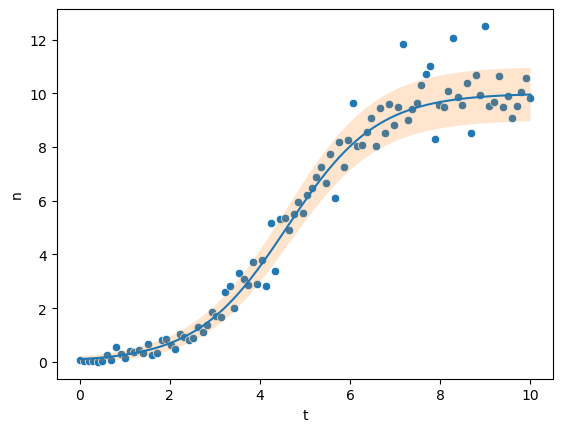

In [3]:
t_lineplot = np.linspace(0, t_max, 100)
n_lineplot_mean = logistic(t_lineplot, k, r, n0)
n_lineplot_sd = np.sqrt(n_lineplot_mean * scale)

sns.scatterplot(x = 't', y = 'n', data = df_data)
sns.lineplot(x = t_lineplot, y = n_lineplot_mean)
plt.fill_between(x = t_lineplot,
                 y1 = n_lineplot_mean - n_lineplot_sd,
                 y2 = n_lineplot_mean + n_lineplot_sd,
                 alpha = 0.2)


### Define statistical model

In [4]:
def logistic_jax(t, k, r, n0):
        n = k / (1. + (k / n0 - 1.) * jax.numpy.exp(-r * t))
        return n

def model(t, n, N):

    k = numpyro.sample('k', dist.HalfCauchy(10.))
    r = numpyro.sample('r', dist.Cauchy(10.))
    n0 = numpyro.sample('n0', dist.HalfCauchy(10.))
    scale = numpyro.sample('scale', dist.HalfCauchy(10.))

    n_mean = logistic_jax(t, k, r, n0)

    with numpyro.plate('data', N):
        numpyro.sample('n', dist.Gamma(n_mean / scale, 1. / scale), obs = n)


### Run MCMC

In [5]:
iter_warmup = 200
iter_sample = 1000
n_chain = 4

numpyro.set_host_device_count(n_chain)
nuts_kernel = numpyro.infer.NUTS(model, adapt_step_size = True)

mcmc = numpyro.infer.MCMC(nuts_kernel, num_warmup = iter_warmup, num_samples = iter_sample,
                          num_chains = n_chain, chain_method = 'parallel')
mcmc.run(jax.random.PRNGKey(0), t = df_data['t'].values, n = df_data['n'].values, N = df_data.shape[0])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

### Plot posteriors

array([[<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'n0'}>,
        <AxesSubplot: title={'center': 'n0'}>],
       [<AxesSubplot: title={'center': 'r'}>,
        <AxesSubplot: title={'center': 'r'}>],
       [<AxesSubplot: title={'center': 'scale'}>,
        <AxesSubplot: title={'center': 'scale'}>]], dtype=object)

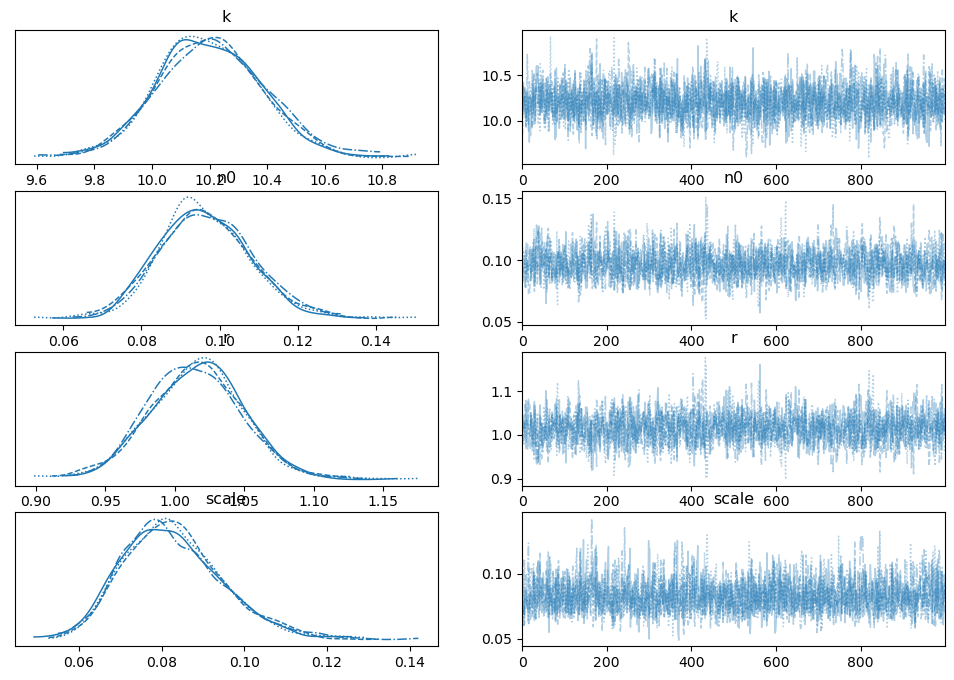

In [6]:
az.plot_trace(mcmc)

### Get summary statistics

In [7]:
dict_diagnostics = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True), prob = 0.95, group_by_chain = True)
df_diagnostics = pd.DataFrame.from_dict(dict_diagnostics)

df_diagnostics

,k,n0,r,scale
mean,10.202814,0.096435,1.015158,0.082979
std,0.183319,0.011746,0.033786,0.012336
median,10.197577,0.095709,1.015514,0.081736
2.5%,9.854436,0.073230,0.949016,0.060573
97.5%,10.567705,0.118404,1.080463,0.108148
n_eff,2063.584710,1622.019435,1583.550530,1993.970682
r_hat,1.002008,1.001410,1.001241,1.000152


### Generate predictive distribution

In [8]:
pred = numpyro.infer.Predictive(model, mcmc.get_samples(group_by_chain = False))

n_bin = 100
t_pred = np.linspace(0, t_max, n_bin)

n_pred = pred(jax.random.PRNGKey(0), t = t_pred, n = None, N = t_pred.shape[0])['n']

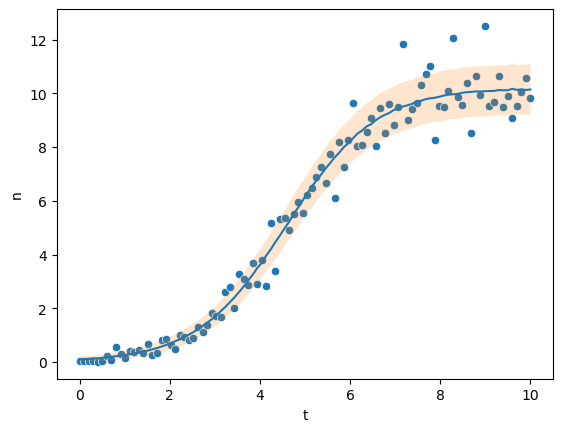

In [9]:
n_pred_mean = n_pred.mean(0)
n_pred_std = n_pred.std(0)

sns.scatterplot(x = 't', y = 'n', data = df_data)
sns.lineplot(x = t_lineplot, y = n_pred_mean)
plt.fill_between(x = t_lineplot,
                 y1 = n_pred_mean - n_pred_std,
                 y2 = n_pred_mean + n_pred_std,
                 alpha = 0.2)
